# Dgemm trace of a real and complete HPL run

In [1]:
import io
import os
import zipfile
import pandas
import yaml
import datetime
import re
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore') # removing annoying warning
import json

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df = pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    df['jobid'] = int(get_yaml(archive_name, 'info.yaml')['jobid'])
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_json(archive_name, json_name):
    archive = zipfile.ZipFile(archive_name)
    return json.load(io.BytesIO(archive.read(json_name)))

In [2]:
def __compute_rank_mapping(archive_name, exp_id):
    '''
    Compute the mapping rank-core, based on mpirun output (thanks to the option --report-bindings).
    '''
    history = get_json(archive_name, 'history.json')
    mpirun = [cmd for cmd in history if cmd['command'].startswith('mpirun') and len(cmd['hostnames']) == 1]
    mpirun = mpirun[exp_id]['stderr'].split('\n')
    regex = re.compile('\[(?P<hostname>[a-z]+-\d+\.[a-z]+\.grid5000\.fr):\d+\] MCW rank (?P<rank>\d+) bound to socket (?P<socket>\d+)\[core (?P<core>\d+)')
    mapping = []
    for line in mpirun:
        match = regex.search(line)
        if match:
            mapping.append({'rank': int(match.group('rank')),
                            'hostname': match.group('hostname'),
                            'socket': int(match.group('socket')),
                            'core': int(match.group('core'))
                           })
    df = pandas.DataFrame(mapping)[['rank', 'hostname', 'socket', 'core']]
    df['node'] = df['hostname'].str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
    df['cpu'] = df['node']*2 + df['socket'] - 2
    return df.sort_values(by='rank').reset_index(drop=True)

def compute_rank_mapping(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    mappings = [__compute_rank_mapping(archive_name, i) for i in range(nb_exp)]
    ref = mappings[0]
    for df in mappings[1:]:
        assert ref.equals(df)
    return ref

In [3]:
hpl_archive = 'calibration_generation/2/grenoble_2020-02-13_1916176.zip'
calibration_archives = {
    'calibration_generation/2/grenoble_2020-02-13_1916194.zip': 'hpl trace',
    'calibration_generation/1/grenoble_2020-02-12_1916052.zip': 'uniform product',    
    'calibration_generation/1/grenoble_2020-02-12_1916072.zip': 'uniform product, fixed K',
    'calibration_generation/1/grenoble_2020-02-12_1916054.zip': 'uniform sizes',
}

def __read_hpl_archive(archive_name, exp_id):
    blas_col = ['file', 'line', 'function', 'rank', 'timestamp', 'duration', 'm', 'n', 'k']
    df = read_csv(archive_name, 'trace_blas_%d.csv' % exp_id, columns=blas_col)
    print('Read trace n°%d from %s: %6d lines' % (exp_id, archive_name, len(df)))
    df['start'] = df.timestamp
    df['end'] = df.timestamp + df.duration
    df = df[['jobid', 'function', 'start', 'end', 'rank', 'm', 'n', 'k', 'duration']]
    df['rank+1'] = df['rank'] + 1
    df['function'] = df['function'].str.strip()
    df['exp_id'] = exp_id
    df['block_size'] = read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]).iloc[exp_id].block_size
    mapping = compute_rank_mapping(archive_name)
    df = df.set_index('rank').join(mapping.set_index('rank')).reset_index()
    return df

def read_hpl_archive(archive_name):
    nb_exp = len(read_csv(archive_name, get_yaml(archive_name, 'info.yaml')['expfile'][0]))
    return pandas.concat([__read_hpl_archive(archive_name, i) for i in range(nb_exp)])

hpl_trace = read_hpl_archive(hpl_archive)

hpl_trace = hpl_trace[hpl_trace['function'] == 'dgemm']
hpl_trace.head()

Read trace n°0 from calibration_generation/2/grenoble_2020-02-13_1916176.zip: 248679 lines


,rank,jobid,function,start,end,m,n,k,duration,rank+1,exp_id,block_size,hostname,socket,core,node,cpu
1,0,1916176,dgemm,0.001446,0.001495,7678.0,2.0,2.0,0.000049,1,0,256,dahu-1.grenoble.grid5000.fr,0,0,1,0
2,0,1916176,dgemm,0.001592,0.001657,7676.0,4.0,4.0,0.000065,1,0,256,dahu-1.grenoble.grid5000.fr,0,0,1,0
3,0,1916176,dgemm,0.001745,0.001770,7674.0,2.0,2.0,0.000025,1,0,256,dahu-1.grenoble.grid5000.fr,0,0,1,0
4,0,1916176,dgemm,0.001865,0.002010,7672.0,8.0,8.0,0.000145,1,0,256,dahu-1.grenoble.grid5000.fr,0,0,1,0
5,0,1916176,dgemm,0.002107,0.002134,7670.0,2.0,2.0,0.000027,1,0,256,dahu-1.grenoble.grid5000.fr,0,0,1,0


In [4]:
hpl_trace[['jobid', 'hostname', 'node']].drop_duplicates().sort_values(by=['jobid', 'node']).reset_index(drop=True)

,jobid,hostname,node
0,1916176,dahu-1.grenoble.grid5000.fr,1


## HPL result

In [5]:
res = read_csv(hpl_archive, 'results.csv')
res[['jobid', 'matrix_size', 'block_size', 'time', 'gflops']].sort_values(by='matrix_size')

,jobid,matrix_size,block_size,time,gflops
0,1916176,60000,256,204.13,705.5


## Checking the parameters

In [6]:
read_csv(hpl_archive, 'exp_hpl.csv')

,matrix_size,block_size,proc_p,proc_q,pfact,rfact,bcast,depth,swap,mem_align,process_per_node,thread_per_process,jobid
0,60000,256,8,4,1,2,2,1,0,8,32,1,1916176


## Prediction error on the duration

In [7]:
import cashew
print(cashew.__git_version__)
import cashew.archive_extraction as ae
import cashew.linear_regression as lr

ca8a64e6735b60bc60c49342320befcdeaf55f90


In [8]:
blas = {}
for archive, mode in calibration_archives.items():
    tmp = ae.read_archive(archive, 'result.csv')
    lr.compute_variable_products(tmp, 'mnk')
    blas[mode] = tmp
blas.keys()

dict_keys(['hpl trace', 'uniform product', 'uniform product, fixed K', 'uniform sizes'])

In [9]:
models = {
    mode: lr.regression(df, 'duration', ['mnk', 'mn', 'mk', 'nk'])
    for mode, df in blas.items()
}
for mode, reg in models.items():
    perf = [proc['avg_gflops'] for proc in reg]
    avg = 1/(sum([1/p for p in perf])/len(perf))  # harmonic mean for gflops
    print('%.2f Gflops | %s' % (avg, mode))

models = {mode: pandas.DataFrame(reg) for mode, reg in models.items()}

26.13 Gflops | hpl trace
26.10 Gflops | uniform product
26.16 Gflops | uniform product, fixed K
26.37 Gflops | uniform sizes


In [10]:
hpl_trace['pred'] = 0
hpl_trace['mnk'] = hpl_trace.m * hpl_trace.n * hpl_trace.k
hpl_trace['mn'] = hpl_trace.m * hpl_trace.n
hpl_trace['mk'] = hpl_trace.m * hpl_trace.k
hpl_trace['nk'] = hpl_trace.n * hpl_trace.k

traces = []
for mode, all_regs in models.items():
    new_trace = hpl_trace.copy()
    for cpu in new_trace['cpu'].unique():
        all_regs['cpu_id'] = 2*all_regs['node'] + all_regs['cpu'] - 2
        reg = all_regs[all_regs['cpu_id'] == cpu]
        assert len(reg) == 1
        reg = list(reg.iterrows())[0][1]
        mask = new_trace['cpu'] == cpu
        new_trace.loc[mask, 'pred'] += reg['intercept']
        for prod in ['mnk', 'mn', 'mk', 'nk']:
            new_trace.loc[mask, 'pred'] += reg[prod] * new_trace[mask][prod]
    new_trace['mode'] = mode
    traces.append(new_trace)
traces = pandas.concat(traces)

In [11]:
duration_thresh = 0.1

In [12]:
traces['error'] = (traces['pred'] - traces['duration']) / traces['duration']
traces['abs_error'] = traces['error'].abs()

In [13]:
traces[traces.duration > duration_thresh]['error'].describe()

count    23184.000000
mean        -0.014462
std          0.032011
min         -0.081819
25%         -0.042680
50%         -0.005866
75%          0.010266
max          0.104623
Name: error, dtype: float64

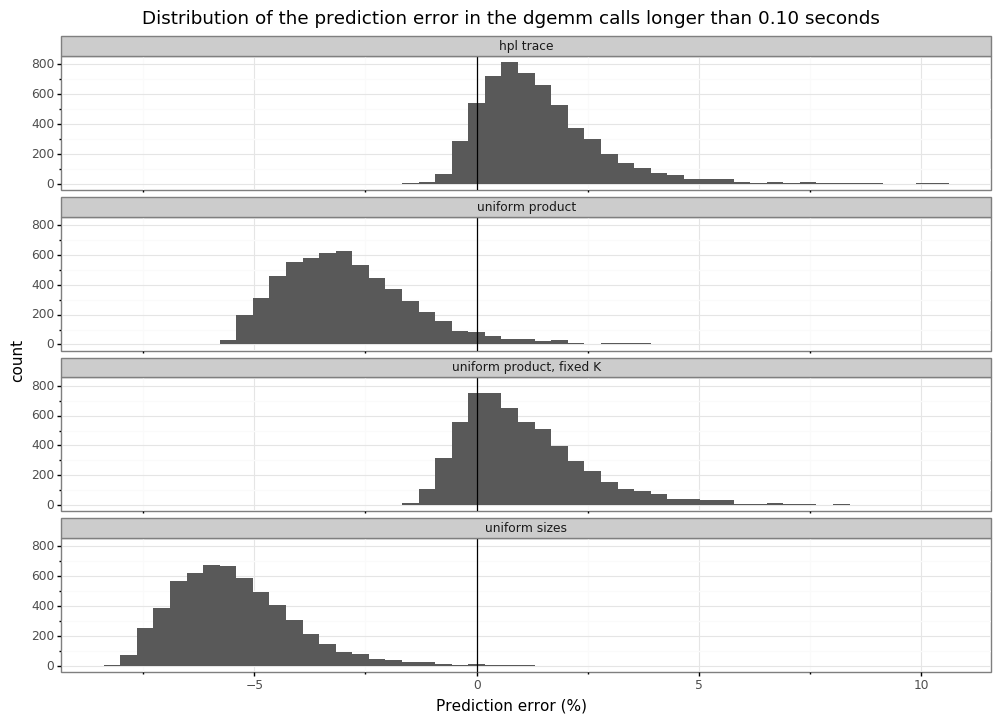

<ggplot: (-9223363242218588244)>

In [14]:
traces['error_perc'] = traces['error']*100
plot = ggplot(traces[traces.duration > duration_thresh], aes(x='error_perc')) + geom_histogram() + theme_bw()
plot = plot + facet_wrap('mode', nrow=4) + xlab('Prediction error (%)')
plot = plot + ggtitle('Distribution of the prediction error in the dgemm calls longer than %.2f seconds' % duration_thresh)
plot = plot + geom_vline(xintercept=0)
plot

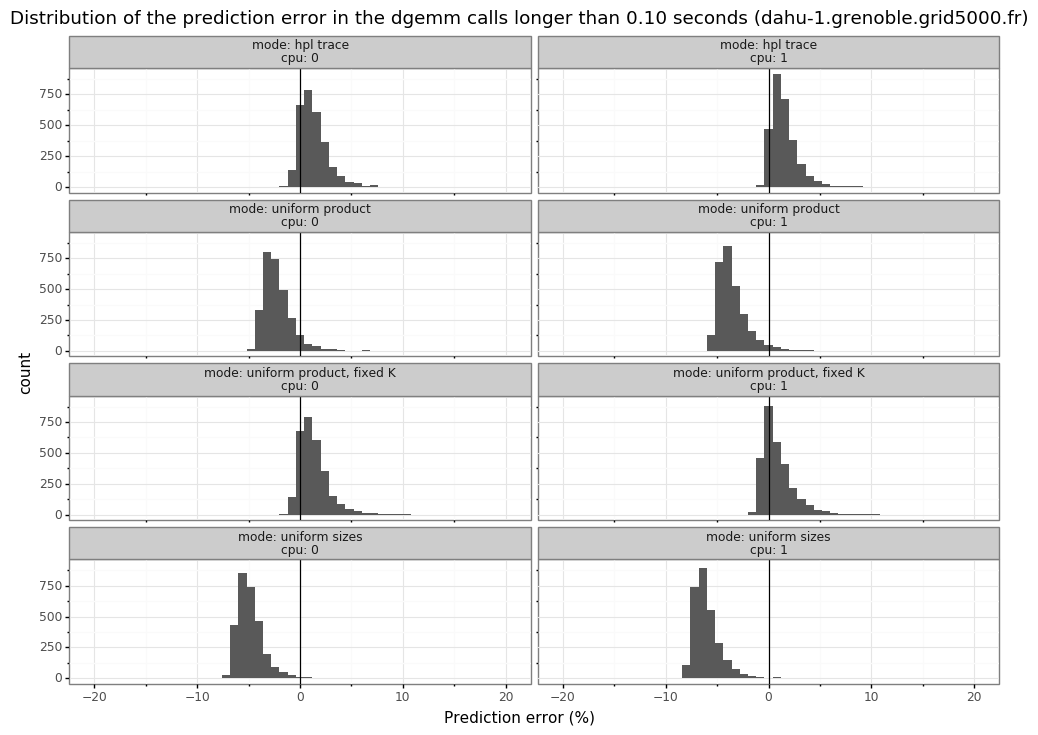

<ggplot: (-9223363242220985491)>


In [15]:
traces['cpu_id'] = traces['cpu']
for node in sorted(traces['node'].unique()):
    tmp = traces[(traces.duration > duration_thresh) & (traces['node'] == node)]
    hostname = tmp.iloc[0]['hostname']
    plot = ggplot(tmp) + aes(x='error_perc') + geom_histogram() + theme_bw()
    plot = plot + facet_wrap(['mode', 'cpu'], ncol=2, labeller='label_both') + xlab('Prediction error (%)')
    plot = plot + ggtitle('Distribution of the prediction error in the dgemm calls longer than %.2f seconds (%s)' % (duration_thresh, hostname))
    plot = plot + geom_vline(xintercept=0)
    plot = plot + expand_limits(x=(-20, 20))
    print(plot)

## Monitoring

In [16]:
def get_monitoring(archive):
    info = ae.read_yaml(archive, 'info.yaml')
    start_exp = pandas.to_datetime(info['timestamp']['run_exp']['start'])
    monitoring = ae.read_archive_csv(archive, 'monitoring.csv')
    cluster = info['cluster']
    site = info['site']
    monitoring['node'] = monitoring['hostname'].str[len(cluster)+1:-(len(site)+len('..grid5000.fr'))].astype(int)
    monitoring['timestamp'] = pandas.to_datetime(monitoring['timestamp'])
    monitoring = monitoring[monitoring['timestamp'] >= start_exp]
    monitoring['start'] = monitoring['timestamp'] - start_exp
    return monitoring

def my_melt(df, prefix, idcol):
    result = []
    columns = [col for col in df.columns if col.startswith(prefix)]
    for col in columns:
        tmp = df[idcol].copy()
        tmp[prefix] = df[col]
        tmp['group'] = int(col[len(prefix):])
        result.append(tmp)
    return pandas.concat(result)

def get_temp_freq(archive, mode):
    monitoring = get_monitoring(archive)
    platform = ae.get_platform(archive)
    mapping = ae.platform_to_cpu_mapping(platform)
    temperature = my_melt(monitoring, 'temperature_core_', ['hostname', 'start', 'node'])
    temperature['cpu'] = temperature.apply(lambda row: mapping[row.group], axis=1)
    frequency = my_melt(monitoring, 'frequency_core_', ['hostname', 'start', 'node'])
    frequency = frequency[frequency['group'] <= max(mapping.keys())]  # removing the cores with largest IDs (they are not real cores, just hyperthreads)
    frequency['cpu'] = frequency.apply(lambda row: mapping[row.group], axis=1)
    frequency['frequency_core_'] *= 1e-9
    temperature['mode'] = mode
    frequency['mode'] = mode
    return temperature, frequency

In [17]:
monitorings = [get_temp_freq(hpl_archive, 'HPL run')]
for archive, mode in calibration_archives.items():
    monitorings.append(get_temp_freq(archive, mode))

temperature = pandas.concat(t[0] for t in monitorings)
frequency   = pandas.concat(t[1] for t in monitorings)

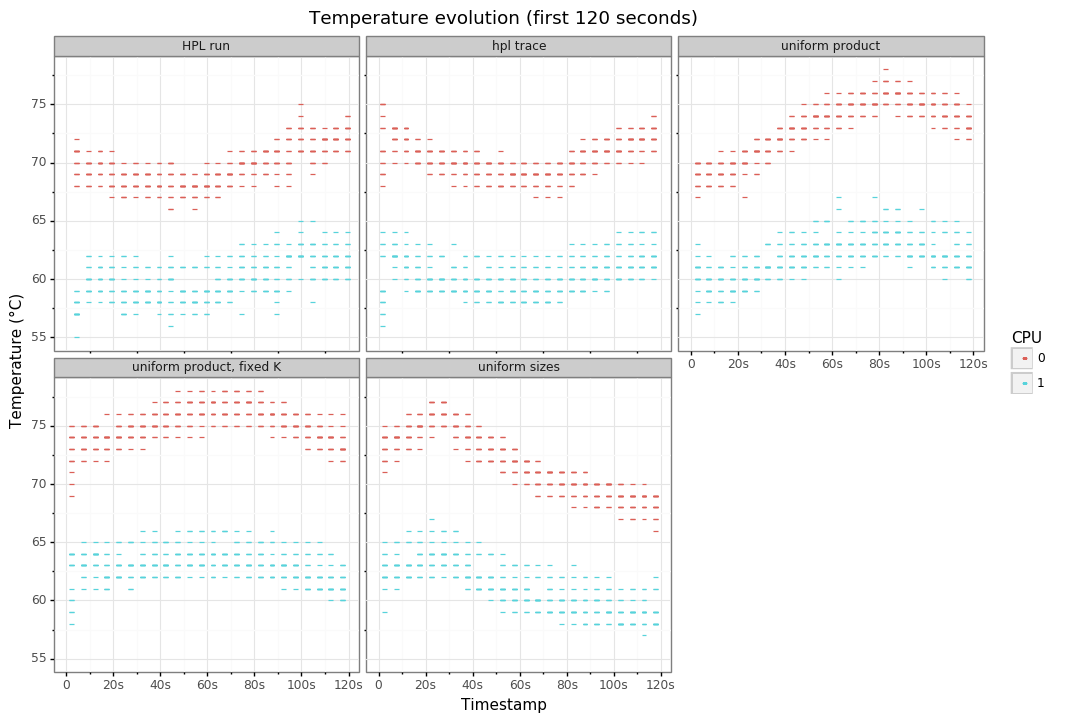

<ggplot: (8794627496631)>

In [18]:
max_time = 120
ggplot(temperature[temperature['start'] <= pandas.to_timedelta(max_time, unit='s')]) +\
    aes(x='start', y='temperature_core_', color='factor(cpu)') +\
    geom_point(shape=1) +\
    facet_wrap('mode') +\
    theme_bw() +\
    xlab('Timestamp') +\
    ylab('Temperature (°C)') +\
    labs(color='CPU') +\
    ggtitle('Temperature evolution (first %d seconds)' % max_time)

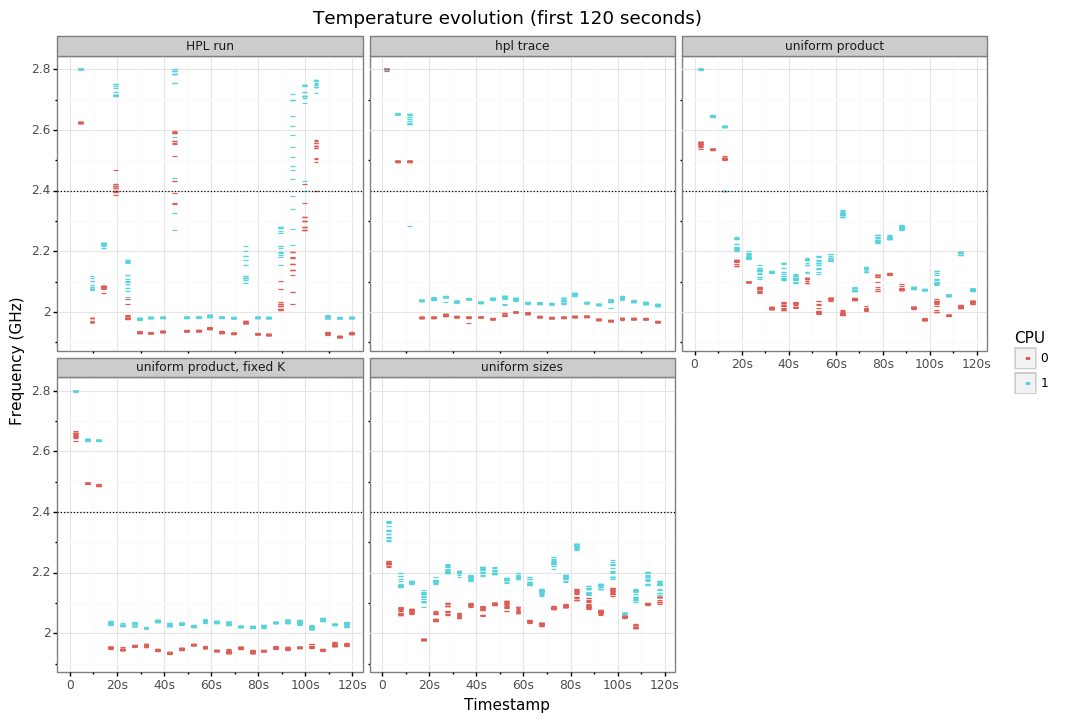

<ggplot: (8794627248455)>

In [19]:
ggplot(frequency[frequency['start'] <= pandas.to_timedelta(max_time, unit='s')]) +\
    aes(x='start', y='frequency_core_', color='factor(cpu)') +\
    geom_point(shape=1) +\
    facet_wrap('mode') +\
    theme_bw() +\
    xlab('Timestamp') +\
    ylab('Frequency (GHz)') +\
    labs(color='CPU') +\
    ggtitle('Temperature evolution (first %d seconds)' % max_time) +\
    geom_hline(yintercept=2.4, linetype='dotted')